*Author: Matthias Franz-Josef Rötzer (c)*

# Byke
_______

## This Document



_Byke_ is a sensorbased tool for a quality-driven analysis of bikelanes

This document shows how to calculate the **happy bike index** of acceleration sensor data recorded with a mobile device. Plots are used to describe the data and results of the applied algorithms. The input data has to be acquired the app *physics-toolbox*. The app delivers formated and geotagged acceleration data recorded with any android or iOS device. 
There are some restrictions.


- input: csv-table (physics toolbox)
- output: geotags of relevant events (:geojson)



Debateable issues and prospects:
- integrity of data 
- event detection 
- classification with support vector machine ( labeling required ) 
_____

In [28]:
import os

import pandas as pd
print 'Pandas:\t' + pd.__version__

import numpy as np
print 'Numpy:\t' + np.__version__

import scipy
import scipy.fftpack
from scipy import pi
from scipy import ndimage
from scipy.stats import *
from scipy.signal import butter, lfilter, freqz
print 'scipy:\t' + scipy.__version__

import pylab

import json

from sklearn.metrics import mean_squared_error

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib
print 'plt:\t' + matplotlib.__version__

#for determining the run time
import time
import datetime

%matplotlib inline
np.random.seed(0)

Pandas:	0.24.2
Numpy:	1.15.2
scipy:	1.1.0
plt:	2.2.3


In [29]:
### global constants

gI = ('gFx','gFy','gFz')
I = ('ax','ay','az')
g = 9.81

## Toolbox

### Data Tools

In [160]:
def first_process(df_, drop_duplicates = 'true'):
    r"""
    in: dataframe with format: -time-ax-ay-az-latitude-longitude
    
        1. format (az,ax,ay) or (gFx, gFz, gFy) as float 
        2. format time column as pandas timestamp
        3. drop for all, timestamp or no duplicates (keep the last value)
    
    :returns 'cleaned' data table, 
        formated (acceleration values, timestamped),
        if desired, cleaned for duplicates 
    """
    
    df_dat = df_
    
    # speed
    if 'Speed (m/s)' in df_dat.columns:
        df_dat.loc[:,'velocity'] = df_dat['Speed (m/s)'].str.replace(",",".").astype(float)
        df_dat = df_dat.drop(columns='Speed (m/s)')
    
    # timestamps
    if 'time' in df_dat.columns:
        df_dat.loc[:,'time'] = pd.to_datetime(df_dat['time'], format = '%H:%M:%S:%f')
        
    if 'Unnamed: 7' in df_dat.columns:
        df_dat = df_dat.drop(columns = 'Unnamed: 7')
    
    # drop last to avoid data loss
    
    # TODO: add loop over I[]
    # linear acceleration
    if 'az' and 'ay' and 'ax' in df_dat.columns:
        if not df_dat['az'].dtypes == np.dtype('float64'):
            df_dat['az'] = df_dat['az'].str.replace(",",".").astype(float)
            df_dat['ay'] = df_dat['ay'].str.replace(",",".").astype(float)
            df_dat['ax'] = df_dat['ax'].str.replace(",",".").astype(float)

        if(drop_duplicates == 'true'):
            df_dat = dropfora(df_dat)
        elif(drop_duplicates == 'time'):
            df_dat = df_dat.drop_duplicates(['Latitude','Longitude','az', 'ay', 'ax'], keep = 'last')
    
    # TODO: add loop over gI[]
    # g-force
    if 'gFz' and 'gFy' and 'gFx' in df_dat.columns:
        if not df_dat['gFz'].dtypes == np.dtype('float64'):
            df_dat['gFz'] = df_dat['gFz'].str.replace(",",".").astype(float)
            df_dat['gFy'] = df_dat['gFy'].str.replace(",",".").astype(float)
            df_dat['gFx'] = df_dat['gFx'].str.replace(",",".").astype(float)

        if(drop_duplicates == 'true'):
            df_dat = dropforg(df_dat)
        elif(drop_duplicates == 'time'):
            df_dat = df_dat.drop_duplicates(['Latitude','Longitude','gFz', 'gFy', 'gFx'], keep = 'last')

    df_dat = df_dat.reset_index(drop=False)
    
    return df_dat 

In [32]:
def normalize(data, thres = 0):
    """
    takes pandas.Series
    any x->(0,1)
    
    """
    
    min_data = min(data)
    maxi_data = max(data)
    
    if thres == 0:
        reach = (maxi_data - min_data)
    else:
        reach = (thres - min_data)

    normalize = pd.Series(data)
    
    for key, val in data.iteritems():
        normalize[key] = (val - min_data)/ reach
        
    return normalize

In [33]:
def standardize(data):
    """
    !bugged!
    statistical standarization (of x):
    z_i = (x_i - x_mean) / x_standardDeviation
    :TODO invariants
    """
    
    descr = data.describe()
    std = descr['std']
    mean = descr['mean']
    
    standardize = pd.Series(data)
    
    for key, val in data.iteritems():
        standardize[key] = (data[key] - mean) / std
    
    return standardize

In [34]:
def calculate_bykeli_index(value, values_before, values_after, std):
    """
    --- old ---
    Returns the Bykeli-Index (-> happy bike index (HBI)) for the given value. 
    
    :std Standard deviation of dataset
    """
    # Calc average value
    l = [value] + list(values_before) + list(values_after)
    l = [abs(x) for x in l]
    avg = float(sum(l)) / float(len(l))
    
    value = avg
    
    MAX = std * 1.3
    i = abs(value)
    i = i / MAX
    i = round(i, 2)
    if i>1:
        return 1
    return i

In [132]:
# tool collection

def import_csv(path_dat):
    try:
        df_dat = pd.read_csv(path_dat, delimiter = ';')
        return df_dat
    except:
        print "import error"

def set_same(x,y):
    """sets two arrays to the same size"""
    shp = min(len(x),len(y))
    return x[:shp],y[:shp]

def dropGeotags(data):
    """ dropping duplicate geotags"""
    len_before = len(data)
    data_dupl = data.drop_duplicates(['Latitude', 'Longitude'], keep = 'last')
    data_dupl = data_dupl.reset_index(drop = 'last')
    
    dropped = len_before - len(data_dupl)
    print "%d duplicates dropped" % dropped
    
    return data_dupl

def rms(series):
    """
    Root Mean Square
    
    aka variance for _stationary_(?) data with zero as gravitational point
    
    :in pandas Series
    :returns rms as a float
    """
    _arr = series
    ms = 0    
    T = len(_arr)
    for i in range(T):
        k = _arr.iloc[i]
        # check if NaN
        if(k == k):
            ms = ms + k**2
        
    ms = ms/T
    
    return np.sqrt(ms)

#drop for 

def dropforg(df):
    return df.drop_duplicates(['gFx','gFy','gFz'], keep='last')

def dropfora(df):
    return df.drop_duplicates(['az','ax','ay'], keep='last')

def checknorm(col):
    return max(col) - min(col) == 1

def hash_me():
    infohash = dict({"title": 0,
                     "n_entries0": 0,
                     "n_entries1": 0,
                     "n_unique_geotags":0,
                     "error_gaussian": 0,
                     "kernel": 0,
                     "threshold": 0,
                     "sigma": 0,
                     "preprocessed": 0,
                     "sigma": 0,
                     "time": 0,
                     "csv_name" : 0
                    })
    return infohash

def returndef(dat, dat2):
    """return defect"""
    deff = abs(len(dat) - len(dat2))
    deffp = round(float(len(dat2))/len(dat) * 100, 2)
    print 'df1: ' +str(len(dat))
    print 'df2: ' +str(len(dat2))
    print str(deff) + '\npercentage: ' + str(100-deffp) + '%'
    
def plotFFT(dat, N):
    r""" 
    +N: frequencies
    """
    
    fft_ = np.fft.fft(dat)
    _, ax = plt.subplots(2, sharex = False, sharey = False, figsize = (10,5))
    ax[0].plot(dat)
    ax[0].grid(linestyle = '--')
    plt.xlabel('Samples')
    plt.ylabel('Acc. $(ms^-1)$')
    
    ax[1].plot(2*np.abs(fft_[:N]/N))
    ax[1].grid(linestyle = '--')
    plt.xlabel('Frequency ($Hz$)')
    plt.ylabel('Amplitude')
    
def floating_RMN(df_col, w_size, N):
    r""" 
    Nth root-mean with certain kernel size
    *using convoltion*
    :in
    + column
    + window size
    + which N-th root mean
    
    :returns 'smoothed' signal """
    window = np.ones(w_size)/float(w_size)
    
    #rms = 'rms_' + str(size)
    
    df_col = np.power(df_col, N)
    dat = (np.convolve(df_col, window, 'same'))**(1./N)
    return dat

def plot_1d_broad(data, ylim = [0,1], log = 'null', name = 'my data'):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(111)
    ax.plot(data)
    ax.grid(True)
    ax.set_ylim(ylim)
    
    #set log
    if(log == 'log'):
        ax.set_yscale("log")
    
    ax.set_title(name)

def summarize(df_dat):
    shp = df_dat.shape[0]
    leng = len(df_dat['Latitude'].unique())
    
    print"total length: %s \nunique geotags: %s" % (str(shp), str(leng))

def plot_XYZ(dat):
    X = dat['ax']
    Y = dat['ay']
    Z = dat['az']

    f, (axx, axy, axz) = plt.subplots(3, sharey = True)
    
    axx.plot((X))
    axx.set_title("X")
    
    axy.plot((Y))
    axy.set_title("Y")
    
    axz.plot((Z));
    axz.set_title("Z")
    
    plt.tight_layout()

def str_to_float(value):
    
    """ old gFone
    3,141 (str) --> 3.141 (float)
    """
    if isinstance(value, float) or isinstance(value, int):
        return float(value)
    else:
        return float(value.replace(',', '.'))    

def totalnorm_LP(dat, P = 2, col = 'both'):
    """
    
    :returns the Total of either linear, gravitational or both accelerations
    """
    if(col == 'g'):
        dat['gFT'] = (dat['gFx']**P + dat['gFz']**P + dat['gFy']**P)**(1./P)
        
    elif(col == 'a'):
        dat['aT'] = (dat['ax']**P + dat['az']**P + dat['ay']**P)**(1./P)
         
    elif(col == 'both'):
        dat['aT'] = (dat['ax']**P + dat['az']**P + dat['ay']**P)**(1./P)
        dat['gFT'] = (dat['gFx']**P + dat['gFz']**P + dat['gFy']**P)**(1./P)
    
        
def range_me(df_, col, high, low,):
    """ 
    :in    dataframe, column, high, low 
    :returns full dataframe with ranged COL
    """
    return df_.loc[(df_[col] > low) & (df_[col] < high)][col]

def dropforspeedzero(df_):
    return df_.loc[df_['velocity'] > 0]

def thres(df_col, t):
    df_r = df_col
    df_r.loc[df_r > t] = t
    return df_r

def dyn_threshold(df_, col, t = 1.5, s=5):
    
    r""" dynamicaly sets the threshold for g force data
    + df_ : dataframe with gFi
    + t : relative to this threshold to be determined 
    + s : seconds of measure 
    
    """
    dat = df_
    
    t = 1.5 # g thres
    fn = getfN(dat[0:5000])
    w_s = s * fn # 5 seconds
    
    
    name_ = col + '_col_t'
    mean_ = rms(dat[col])
    
    dat_mean = dat[col].rolling(w_s, win_type = 'boxcar').mean()
    dat_mean = dat_mean.replace(np.NaN, mean_)
    
    dat[name_] = dat[col]
    dat[name_].loc[dat[col] > (dat_mean + t)] = dat_mean + t
    dat[name_].loc[dat[name_] < (dat_mean - t)] = dat_mean - t
    
    return dat

In [67]:
def average_geotags(data, col = 'azg'):
    
    """
    :in pandas DataFrame with 
            - geotags 'Latitude' and 'Longitude' 
            - positive acceleration data 'az' (HBI)
    
    :TODO make it euclidean ( -> sqrt(N^2))
    
    :returns geotags with moving average of the z-acceleration(az)
    
    """
    df = data
    
    #check for zeros 
    # Latitude & Longitude are dtype 'O' (object)...
    df = df[df['Latitude'] != '0,00000000']
    df = df.reset_index(drop = 1)
    
    df_geotags = pd.DataFrame(columns = [col, 'Latitude', 'Longitude'])
    i = 0
    k = 0

    lat = df['Latitude'].iloc[0]
    lon = df['Longitude'].iloc[0]

    sum1 = 0

    while(i < df.shape[0]-1):
        if(lat == df['Latitude'].iloc[i+1] and lon == df['Longitude'].iloc[i+1]):
            sum1 += df[col].iloc[i]
            k += 1
            i += 1
        else:
            avg = sum1/k
            df_geotags.loc[i] = [avg, lat, lon]
            k = 0
            sum1 = 0
            i += 1
            lat = df['Latitude'].iloc[i]
            lon = df['Longitude'].iloc[i]
            
    return df_geotags


In [68]:
def gauss_me(g_kernel, sigma, mu = 0):
    """gaussian vector"""
    k = g_kernel//2
    window = np.linspace((-k)+mu,(k+mu),g_kernel)
    
    g = np.exp(-((window-mu)**2 / ( 2.0 * sigma**2 ) ) )/ np.sqrt(2*np.pi*sigma**2)
    
    return g

In [69]:
## high runtime wtf?
# just take [1:10000] samples

def getfN(df_):
    """
    make sure stamp is 'time'
    
    just take a sample size of the dataframe not all
    
    returns sampling rate f_n in 1/s
    derived from sampling distance T, where T = 1/f_n
    """
    
    try:
        df_ = df_.reset_index()
    except:
        print 'already reindexed'
    
    delta = []
    
    for i in range(len(df_)-1):
        d =  df_.loc[i+1]['time'] - df_.loc[i]['time']
        delta = np.append(delta, d.total_seconds())
    
    return int(round(1/delta.mean()))

### Butterworth filters

In [139]:
def lowpass_butter(cutoff, fs, order=5):
    nyq = 0.5 * fs
    cutoff_n = cutoff / nyq
    b, a = butter(order, cutoff_n, btype='low', analog=False)
    return b, a

def highpass_butter(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = highpass_butter(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def passmehigh(dat, col, cutoff, fs, order):
    _ = 'bhp_%sHz' %str(cutoff) # column name
    dat[_] = butter_highpass_filter(dat[col], cutoff, fs, order)

Systemic Error:
2.8412453161985596e-05


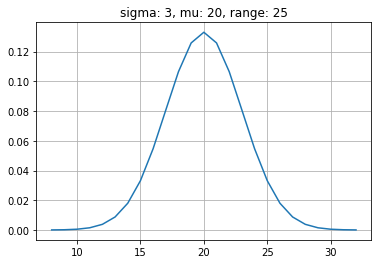

In [70]:
# discrete gaussian function 

kern, m, sig = 25, 20, 3
k = kern//2

window = np.linspace((-k)+m,(k+m),kern)
gw = gauss_me(kern,sigma = sig,mu=m)

_ = 'sigma: %d, mu: %d, range: %d' % (sig, m, kern)
plt.title(_)
plt.plot(window, gw)
plt.grid()

print 'Systemic Error:'
print 1-gw.sum()

In [72]:
from math import * #radians, cos, sin, asin, sqrt

# Haversine algorithm 
# picked from:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine me  
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371.
    return c * r

# haversine for dataframe

def haversineDistance(dat, strchanged = True):
    """ 
    needs 'Longitude' and 'Latitude' column 
    adds a distance column and calculates the distnace between each geotag
    
    """
    
    if not(strchanged):
        dat['Longitude'] = dat['Longitude'].str.replace(",",".").astype(float)
        dat['Latitude'] = dat['Latitude'].str.replace(",",".").astype(float)

    for i in range(len(dat)-1):
        lon1 = dat.loc[i,'Longitude']
        lat1 = dat.loc[i,'Longitude']  
        lon2 = dat.loc[i+1,'Longitude']
        lat2 = dat.loc[i+1,'Longitude']
        dat.loc[i,'distance(m)'] = haversine(lon1,lat1,lon2,lat2) * 1000

    return dat


In [137]:
haversineDistance(dat, strchanged = False)

,index,time,gFx,gFy,gFz,Azimuth,Pitch,Roll,Latitude,Longitude,Unnamed: 10,velocity,gFz_col_t,distance(m)
0,0,1900-01-01 12:15:32.530,-0.0264,-0.0186,1.0974,"-125,861","0,969","1,377",0.000000,0.000000,NaN,0.000000,1.0974,0.0
1,2,1900-01-01 12:15:32.533,-0.0401,0.0039,1.0525,"-127,905","-0,213","2,180",0.000000,0.000000,NaN,0.000000,1.0525,0.0
2,3,1900-01-01 12:15:32.534,-0.0772,0.0362,1.0056,"-128,189","-2,053","4,390",0.000000,0.000000,NaN,0.000000,1.0056,0.0
3,4,1900-01-01 12:15:32.536,-0.0997,0.0547,0.9792,"-128,155","-3,182","5,812",0.000000,0.000000,NaN,0.000000,0.9792,0.0
4,5,1900-01-01 12:15:32.537,-0.0899,0.0440,0.9860,"-127,767","-2,543","5,210",0.000000,0.000000,NaN,0.000000,0.9860,0.0
5,6,1900-01-01 12:15:32.540,-0.0694,0.0205,1.0222,"-126,760","-1,148","3,883",0.000000,0.000000,NaN,0.000000,1.0222,0.0
6,7,1900-01-01 12:15:32.541,-0.0547,0.0039,1.0603,"-125,999","-0,211","2,955",0.000000,0.000000,NaN,0.000000,1.0603,0.0
7,9,1900-01-01 12:15:32.544,-0.0489,-0.0029,1.0730,"-126,066","0,156","2,607",0.000000,0.000000,NaN,0.000000,1.0730,0.0
8,10,1900-01-01 12:15:32.545,-0.0469,0.0020,1.0564,"-127,102","-0,106","2,542",0.000000,0.000000,NaN,0.000000,1.0564,0.0
9,11,1900-01-01 12:15:32.550,-0.0596,0.0186,1.0261,"-128,118","-1,035","3,325",0.000000,0.000000,NaN,0.000000,1.0261,0.0


## geoJSON Toolbox

In [74]:
def index_to_color(index):  
    """
    return color for value between 0 and 1 
    
    color gradient green, yellow, red 
    """
    color_gradient = [
            '#2bff00', '#74ff00', '#9eff00', '#bfff00', '#dcff00',
            '#ebef00', '#f7e000', '#ffd000', '#ffad00', '#ff8700',
            '#ff5b00', '#ff0000'
        ]
    i = index * len(color_gradient)
    i = int(round(i)) - 1
    if(i<=0):
        return color_gradient[0]
    return color_gradient[i]

In [75]:
color_gradient = [
            '#2bff00', '#74ff00', '#9eff00', '#bfff00', '#dcff00',
            '#ebef00', '#f7e000', '#ffd000', '#ffad00', '#ff8700',
            '#ff5b00', '#ff0000'
        ]

In [77]:
def df_to_geojson(df, export_path=None, lat_row='Latitude', lng_row='Longitude'):
    """ 
   
    Konvertiert das Dataframe der GPS Sensoraufnahme (GPS.csv) in GeoJSON (ohne Index-Berechnung). 
    """
    points = []
    for i in range(0, len(df)):
        x = df.iloc[i]
        p = Point(str_to_float(x[lng_row]), str_to_float(x[lat_row]))
        
        points.append(p)
    
    _geojson = GeometryCollection(points)
    
    if export_path:
        f = open (export_path, 'w')
        f.write(json.dumps(_geojson))
    return _geojson


In [78]:
def df_geojson(df, col):
    
    """
    exporting arbitrary df to geoJSON
    
    df has to have Following format:
    
    col describes the source column
    its values have to be normalized between 0 and 1
    
    'az'%'ax'%'ay'%'Longitude'%'Latitude'
    
    """
    entries = []
    for i in range(0, len(df)):

        item = df.iloc[i]
        lng = str_to_float(item['Longitude'])
        lat = str_to_float(item['Latitude'])
        index = item[col]

        entry = {'lng': lng, 
                'lat': lat, 
                'index': index
                }

        entries.append(entry)

    ## Convert to GeoJSON
    features = []
    for i in range(0, len(entries)-2):
        x = entries [i]
        y = entries[i+1]
        line = LineString([(x['lng'], x['lat']), 
                           (y['lng'], y['lat'])])
        
        feature = Feature(geometry=line, properties={
            "index": x['index'],
            "stroke": index_to_color(x['index']),
            "stroke-width": 2,
            "stroke-opacity": 1
        })

        features.append(feature)

    _geojson = FeatureCollection(features)
    
    return _geojson

### Processing proposal

In [378]:
def process_df(df_dat, infohash, sigma, seconds, axis = 'az', export = 0, threshold = 4.):
    
    """
    Too much for a function... 
    
    modularize...
    
    Processes the given data frame, calculates the Bykeli-Index from linear acceleration 
    and returns the result as GeoJSON
    
    :TODO
    add sampling rate as parameter
    complete infohash
    :returns GeoJSON object
    """
    
    tic = time.clock()
    
    infohash['export'] = export
    
    infohash['sigma'] = sigma
    infohash['threshold'] = threshold
    
    # step 1 
    # formating and cleanup of data
    
    df = df_dat
    
    if(infohash['preprocessed'] == 0):
        df = first_process(df)
        df = df.loc[:,[axis,'Latitude','Longitude', 'time']]
        infohash['preprocessed'] = 1
    
    df[axis] = abs(df.loc[:][axis])
    # acceleration above 't' m/s^2
    df[axis] = thres(df.loc[:][axis], threshold)

    descr = df.describe()
    # descr['az']['count']
    infohash['n_entries0'] = descr[axis]['count']
    
    infohash['f_n'] = getfN(df[:5000])
    infohash['sampling_distance'] = 1./infohash['f_n']
    
    # step 2 
    # denoising
    
    mu, g_sigma = 0, infohash['sigma']
    g_kernel = infohash['f_n'] * seconds
    infohash['kernel'] = g_kernel
    gwindow = gauss_me(g_kernel, g_sigma, mu)
    
    plt.figure(figsize=(11,5))
    plt.plot(df[axis], alpha = 0.4)
    
    ## get error value
    infohash['error_gaussian'] = abs(1-gwindow.sum())

    ## convolution with G and ignoring the borders ('same')
    df.loc[:,'ag'] = np.convolve(gwindow, df[axis], 'same')
    
    l_gauss = 'gaussian(sigma:{})'.format(str(infohash['sigma']))
    plt.legend(('raw absolutes',g_sigma))
    
    plt.grid()
    plt.plot(df['ag'])
    
    # step 3 
    # calculate HBI 
    # :TODO this drops the indices
    
    infohash['n_entries1'] = len(df)
    
    # :TODO
    #infoshash['RMS'] = rms(SERIES)
    
    ## reindex 
    df['index_key'] = df.index
    df = df.reset_index(drop = 'true')
    ## averages of geotags
    avg_g = average_geotags(df, col = 'ag')
    infohash['n_unique_geotags'] = len(avg_g)
    ## standardize df -> {[0,1)}
    
    avg_g['ag'] = normalize(avg_g['ag'])
    
    df = avg_g
    
    print df.head()
    
    # step 4 export
    
    # same functionality as df_geojson()...
    
    entries = []
    for i in range(0, len(df)):

        item = df.iloc[i]
        lng = str_to_float(item['Longitude'])
        lat = str_to_float(item['Latitude'])
        index = item['ag']

        entry = {'lng': lng, 
                'lat': lat, 
                'index': index
                }

        entries.append(entry)
    
    ## Convert to GeoJSON
    features = []
    for i in range(0, len(entries)-2):
        x = entries [i]
        y = entries[i+1]
        line = LineString([(x['lng'], x['lat']), 
                           (y['lng'], y['lat'])])
        feature = Feature(geometry=line, properties={
            "index": x['index'],
            "stroke": index_to_color(x['index']),
            "stroke-width": 2,
            "stroke-opacity": 1
        })
        
        features.append(feature)
        
    _geojson = FeatureCollection(features)
    
    toc = time.clock()
    infohash['time'] = toc-tic
    
    if export:
        name = 'hbi'
        directory = os.getcwd()
        export_path =  directory + '/data/processed/' + name + '_s{}_kernel{}_'.format(infohash['sigma'],infohash['kernel'])
        dump(_geojson, export_path)
        print "\n exported .geoJSON to:\n" + export_path + "processed.geojson"
    
    return FeatureCollection(features), df

# Test run (importing and processing)

- imports in this section are done 'manually' to keep track of the variable names
- processing includes data cleanup

### Datasets

In [81]:
# (linear acceleration) hackathon & older datasets from different devices 
# w Geotags

df_dom = import_csv(path_dat = root + 'data_dom.csv')
df_swa = import_csv(path_dat = root + 'zurswa.csv')
df_polizei = import_csv(path_dat = root + 'polizei.csv')

In [1]:
import Tkinter
import tkFileDialog

Tkinter.Tk().withdraw() # Close the root window
in_path = tkFileDialog.askopenfilename()
print in_path


In [82]:
# cleanup

print help(first_process)
df_swa = first_process(df_swa, drop_duplicates='time')
df_dom = first_process(df_dom, drop_duplicates='time')
df_polizei = first_process(df_polizei, drop_duplicates='time');

Help on function first_process in module __main__:

first_process(df_, drop_duplicates='true')
    in: dataframe with format: -time-ax-ay-az-latitude-longitude
    
        1. format (az,ax,ay) or (gFx, gFz, gFy) as float 
        2. format time column as pandas timestamp
        3. drop for all, timestamp or no duplicates (keep the last value)
    
    :returns 'cleaned' data table, 
        formated (acceleration values, timestamped),
        if desired, cleaned for duplicates

None


In [367]:
# (raw acceleration w g Force) from Huawei 

## hercules / tsunoda tracks 'uni <-> home' with direction back and forth 

# could be written better...

df_backpack = import_csv(path_dat = root + 'TsunodaBackpack0803.csv') # unfixed, no orientation
df_forth1 = import_csv(path_dat = root + 'hercules_uni_forth1_huawei.csv')
df_forth2 = import_csv(path_dat = root + 'hercules_uni_forth2_huawei.csv')
df_forth3 = import_csv(path_dat = root + 'hercules_uni_forth3_huawei.csv')
df_back   = import_csv(path_dat = root + 'hercules_uni_back_huawei.csv')
df_forth4_rb = import_csv(path_dat = root + 'tsunoda_uni_forth4_huawei.csv')
df_forth5 = import_csv(path_dat = root + 'hercules_uni_forth5_huawei.csv')
df_back2_rb = import_csv(path_dat = root + 'df_back2_rb.csv')

In [368]:
df_backpack = first_process(df_backpack, drop_duplicates='true')
df_forth1 = first_process(df_forth1, drop_duplicates='true')
df_forth2 = first_process(df_forth2, drop_duplicates='true')
df_forth3 = first_process(df_forth3, drop_duplicates='true')
df_back = first_process(df_back, drop_duplicates='true')
df_forth4_rb = first_process(df_forth4_rb, drop_duplicates='true')
df_forth5 = first_process(df_forth5, drop_duplicates='true');
df_back2_rb = first_process(df_back2_rb, drop_duplicates='true');

In [375]:
df_back2_rb.describe()

,index,gFx,gFy,gFz,Unnamed: 10,velocity
count,78494.000000,78494.000000,78494.000000,78494.000000,0.0,78494.000000
mean,46721.179593,-0.073163,-0.005900,1.013928,NaN,6.418791
std,26544.803004,0.182768,0.256472,0.263292,NaN,1.833940
min,0.000000,-2.712800,-3.308900,-3.427100,NaN,0.000000
25%,24142.250000,-0.164200,-0.096700,0.919600,NaN,7.125564
50%,46858.500000,-0.068400,-0.010700,1.019200,NaN,7.125564
75%,69552.500000,0.014700,0.080100,1.116000,NaN,7.125564
max,92566.000000,1.947600,4.295900,4.443400,NaN,8.544710


In [85]:
df_forth2.head()

,index,time,gFx,gFy,gFz,Azimuth,Pitch,Roll,Latitude,Longitude,Unnamed: 10,velocity
0,0,1900-01-01 12:13:10.164,0.0997,0.0254,1.1756,"-151,155","-1,234","-4,846","0,00000000","0,00000000",NaN,0.0
1,1,1900-01-01 12:13:10.165,0.0977,0.0440,1.1903,"-151,427","-2,109","-4,694","0,00000000","0,00000000",NaN,0.0
2,2,1900-01-01 12:13:10.167,0.1007,0.0020,1.1092,"-150,907","-0,101","-5,185","0,00000000","0,00000000",NaN,0.0
3,4,1900-01-01 12:13:10.169,0.1329,-0.0195,0.9205,"-154,187","1,204","-8,215","0,00000000","0,00000000",NaN,0.0
4,5,1900-01-01 12:13:10.170,0.1290,0.0264,0.8404,"-155,999","-1,777","-8,726","0,00000000","0,00000000",NaN,0.0


In [86]:
df_dom.head()

,index,time,ax,ay,az,Latitude,Longitude,velocity
0,6,1900-01-01 03:14:05.673,-0.0021,-0.0007,0.0014,"48,37163497","10,89763117",0.0
1,24,1900-01-01 03:14:05.924,-0.0057,0.0005,-0.0003,"48,37163497","10,89763117",0.0
2,38,1900-01-01 03:14:06.122,-0.0022,-0.0015,-0.0009,"48,37163497","10,89763117",0.0
3,52,1900-01-01 03:14:06.326,0.0015,-0.0050,0.0008,"48,37163497","10,89763117",0.0
4,66,1900-01-01 03:14:06.527,-0.0047,0.0030,-0.0016,"48,37163497","10,89763117",0.0


sampling rate f_s100


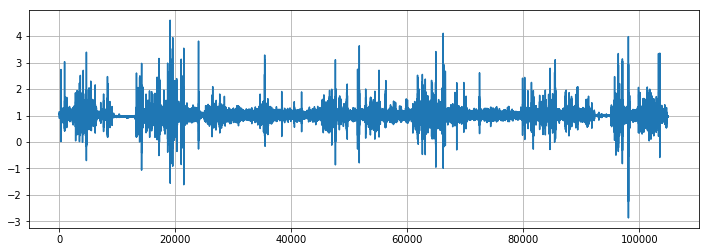

In [386]:
# what does the raw g force acceleration data look like?
dat = df_forth1
col = gI[2]
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(dat[col]);
print 'sampling rate f_s' + str(getfN(dat[:4000]))

          ag     Latitude    Longitude
27  0.000000  48,37163497  10,89763117
33  0.025749  48,37138519  10,89776818
39  0.059417  48,37141779  10,89782756
45  0.063825  48,37135772  10,89780973
51  0.016344  48,37133100  10,89785437


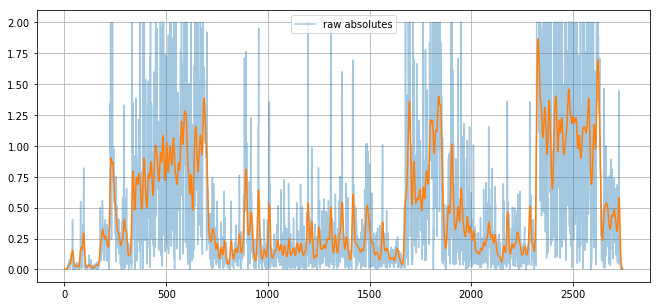

In [400]:
# HBI w gaussian convolution 
dat = df_dom
col = I[2]
infohash = hash_me()
infohash['preprocessed'] = 1
processed, df = process_df(dat, infohash, seconds = 10, sigma = 4, threshold=4., axis = col);

In [394]:
infohash

{'csv_name': 0,
 'error_gaussian': 0.016666666666686814,
 'export': 0,
 'f_n': 6,
 'kernel': 60,
 'n_entries0': 2745.0,
 'n_entries1': 2745,
 'n_unique_geotags': 410,
 'preprocessed': 1,
 'sampling_distance': 0.16666666666666666,
 'sampling_rate': 0,
 'sigma': 4,
 'threshold': 2.0,
 'time': 5.131730999999945,
 'title': 0}

In [401]:
import folium

def style_function(feature):
    return {
        "color": feature['properties']['stroke'],
        "stroke-width": 2.5,
        "stroke-opacity": 1
      }

m = folium.Map(location=[48.37142643, 10.89786328], zoom_start=19)
#folium.GeoJson(_geojson, name='bikeindex', style_function=style_function).add_to(m)
folium.GeoJson(processed, name='happybikeindex', style_function=style_function).add_to(m)

folium.TileLayer('cartodbpositron').add_to(m)

In [397]:
folium.GeoJson(processed, name='happybikeindex', style_function=style_function).add_to(m)

In [402]:
m

In [362]:
diff

array([ 0.0147, -0.0811, -0.1887, ...,  0.0361,  0.0733,  0.1085])

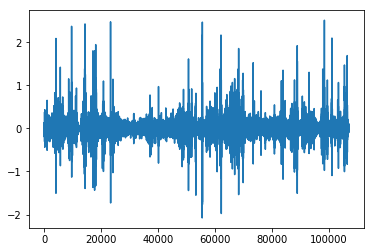

In [223]:
plt.plot(diff)

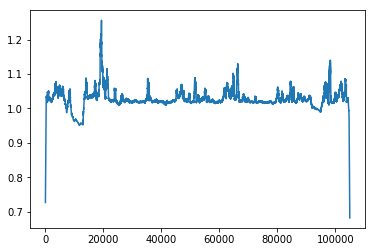

In [177]:
plt.plot(rmn)

data:  [28, 70, 25, 8, 90, 77, 58, 11, 80, 77]
weighted data:  [14.0, 17.5, 3.125, 0.5, 2.8125, 1.203125, 0.453125, 0.04296875, 0.15625, 0.0751953125]
weighted avg:  39.8681640625


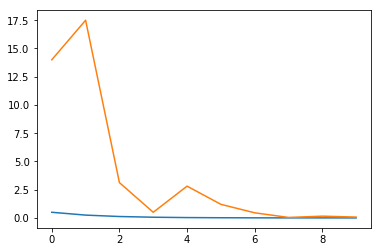

In [363]:
'''
simple exponential smoothing
go back to last N values
y_t = a * y_t + a * (1-a)^1 * y_t-1 + a * (1-a)^2 * y_t-2 + ... + a*(1-a)^n * y_t-n
'''
from random import random,randint

def gen_weights(a,N):
    ws = list()
    for i in range(N):
        w = a * ((1-a)**i)
        ws.append(w)
    return ws

def weighted(data,ws):
    wt = list()
    for i,x in enumerate(data):
        wt.append(x*ws[i])
    return wt

N = 10
a = 0.5
ws = gen_weights(a,N)
data = [randint(0,100) for r in xrange(N)]
weighted_data = weighted(data,ws)
print 'data: ',data
plt.plot(ws)
plt.plot(weighted_data)
print 'weighted data: ',weighted_data
print 'weighted avg: ',sum(weighted_data)

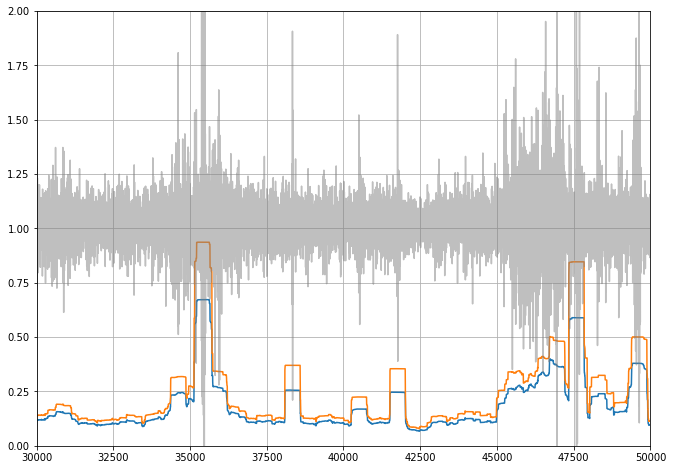

In [412]:
# compare different floating root mean orders

w_size = 500
col = gI[2]

dat = df_forth1[col]
rmn = floating_RMN(dat-1, w_size, 4)
rmn2 = floating_RMN(dat-1, w_size, 6)

plt.figure(figsize = (11,8))
plt.plot(rmn)
plt.plot(rmn2)
plt.plot(dat,'grey', alpha = 0.5)
plt.ylim((0,2))
plt.xlim(30000,50000)
plt.grid()
plt.savefig('compare_root_mean_float.pdf')

In [414]:
smoothed = dat.rolling(50, min_periods=50, center=False)

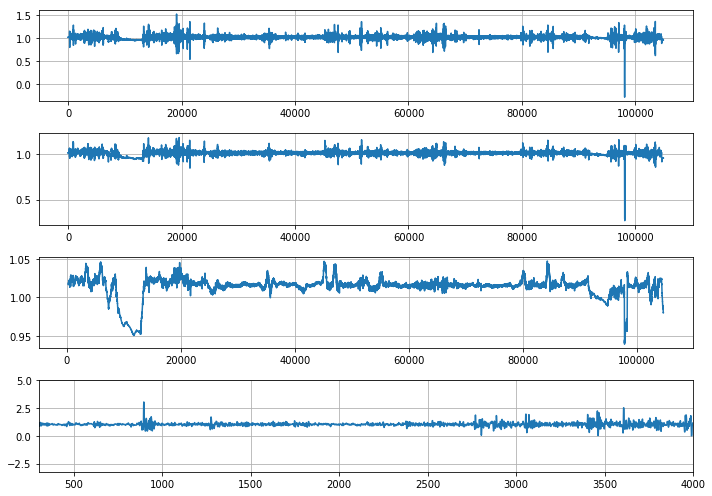

In [423]:
dat = df_forth1['gFz'].reset_index(drop = 1)
#dat = df_swa['az']

rollme = dat.rolling(20, center=True)
rollme50 = dat.rolling(50, center=True)
rollme100 = dat.rolling(500, center=True)

stdz = rollme.mean()
std50 = rollme50.mean()
std100 = rollme100.mean()

f, ax = plt.subplots(4,1, sharey = False, figsize = (10,7))
l = 0
h = len(dat)
t = 0.6
ax[0].plot(stdz[l:h])
#ax[0].plot([l,h], [t,t], 'r--')

ax[1].plot(std50[l:h])
ax[2].plot(std100[l:h])
ax[3].plot(dat[l:h])

#for i in ax: ax[i].grid()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

f.tight_layout()

In [226]:
len(df_forth3)

101630

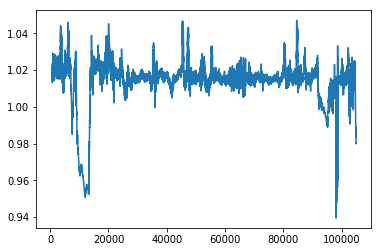

In [409]:
# 5 second window

dat = df_forth1['gFz']
dat_mean = dat.rolling(500, win_type = 'boxcar').mean()
plt.plot(dat_mean)
#plt.plot(dat)

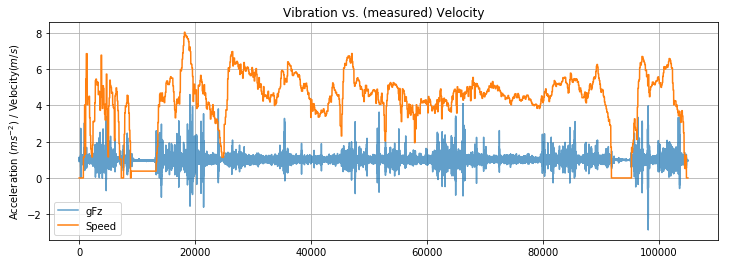

In [426]:
# vibrations vs speed

dat = df_forth1

plt.figure(figsize = (12,4))
plt.plot(dat['gFz'], alpha = 0.7)
plt.plot(dat['velocity'])
plt.legend(['gFz','Speed'])
plt.ylabel('Acceleration ($ms^{-2}$) / Velocity($m/s$)')
plt.title('Vibration vs. (measured) Velocity')
plt.grid()
plt.savefig('df_forth_velocity.pdf')

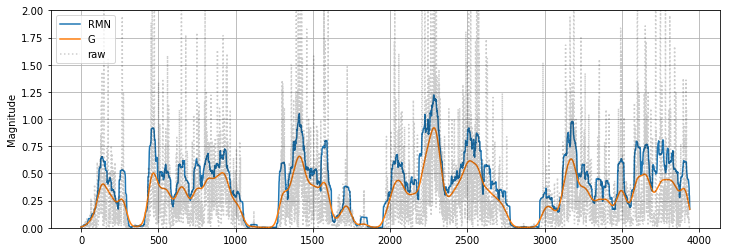

In [411]:
dat = df_swa

dat['RMN_41_2'] = floating_RMN(dat['az'], 41, 2)

#choose mu -Kernel//2
g_w = gauss_me(g_kernel=201, mu=100,sigma=25)

dat['gaussed_s25_k201'] = np.convolve(g_w,abs(dat['az']), mode='same')
dat['az'] = thres(abs(dat['az']), t= 4.)
#dat['tgaussed_s25_k201'] = np.convolve(g_w,abs(dat['az']), mode='same')
dat = dat.reset_index(drop = 1)

plt.figure(figsize=(12,4))
plt.plot(dat['RMN_41_2'])
plt.plot(dat['gaussed_s25_k201'])

#plt.plot((df_fora['az']))
#plt.plot(dat_RMN.cumsum())
#plt.plot(dat_G.cumsum())


plt.grid()
plt.plot(abs(dat['az']), 'k:', alpha = 0.2)
plt.ylabel('Magnitude')
plt.ylim(0,2)
plt.legend(('RMN', 'G','raw'))
plt.savefig('rmn_compare.pdf')

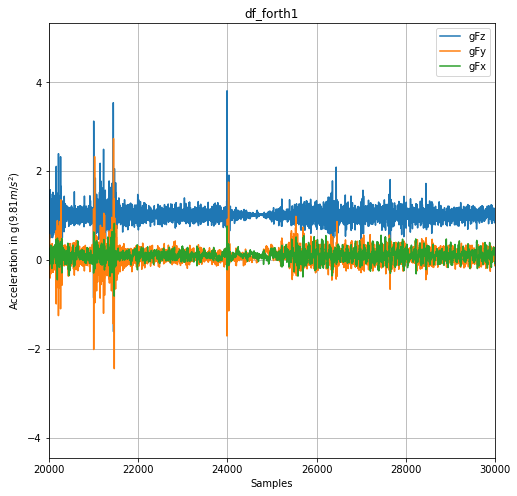

In [457]:
dat = df_forth1
plt.figure(figsize=(8,8))
plt.plot(dat['gFz'])
plt.plot(dat['gFy'][:])
plt.plot(dat['gFx'])
plt.legend()
plt.ylabel('Acceleration in g$(9.81m/s^2)$')
plt.xlabel('Samples')
plt.grid()
plt.title('df_forth1');
plt.xlim(20000,30000)
# plt.savefig('df_forth1.pdf')

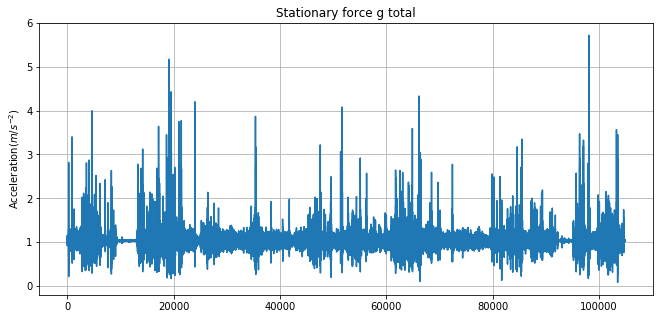

In [460]:
#dat = df_forth2
plt.figure(figsize = (11,5))
totalnorm_LP(dat,2, col ='g')
plt.plot(dat['gFT'])
plt.title('Stationary force g total');
plt.ylabel('Acceleration($m/s^{-2}$)')
plt.grid()

plt.savefig('total_gFi.pdf')

In [344]:
df_forth1.describe()

,index,gFx,gFy,gFz,velocity,col_t
count,104962.000000,104962.000000,104962.000000,104962.000000,104962.000000,104962.000000
mean,65810.635963,0.122830,0.081819,1.013768,4.248579,1.013561
std,37880.700977,0.119009,0.166399,0.181533,1.659493,0.174394
min,0.000000,-2.088300,-4.005600,-2.866200,0.000000,-0.551360
25%,33083.250000,0.054700,0.006800,0.948900,3.835260,0.948900
50%,65861.500000,0.113400,0.081100,1.007500,4.558875,1.007500
75%,98603.500000,0.180800,0.155400,1.079800,5.197624,1.079800
max,131363.000000,1.431600,4.892000,4.597800,8.036943,2.540976


In [343]:
df_dom.describe()

,index,ax,ay,az,velocity
count,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000
mean,16553.092896,-0.004030,-0.030555,-0.017710,3.244517
std,9546.700858,0.455404,0.430581,0.939973,1.127246
min,6.000000,-2.130200,-2.336800,-13.621300,0.000000
25%,8288.000000,-0.240900,-0.268000,-0.200800,2.830000
50%,16478.000000,0.006400,-0.025400,0.014700,3.450000
75%,24967.000000,0.251500,0.190200,0.269600,4.050000
max,33131.000000,2.547700,2.281500,3.692400,5.300000


In [345]:
rms(df_dom['az'])

0.9399681524155785

(20000, 21000)

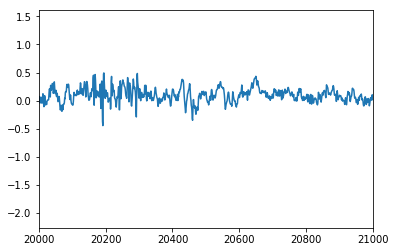

In [341]:
plt.plot(df_forth1['gFx'])
plt.xlim(20000,21000)

### Butterworth filtering

In [325]:
dat = df_forth3
col = gI[2]


fs = round(getfN(dat[:5000]),2)
dat = dyn_threshold(dat, col)
print fs

99.0


In [326]:
cutoff = 1.
colpass = str(col) + '_col_t'
passmehigh(dat,colpass,cutoff,fs,order)

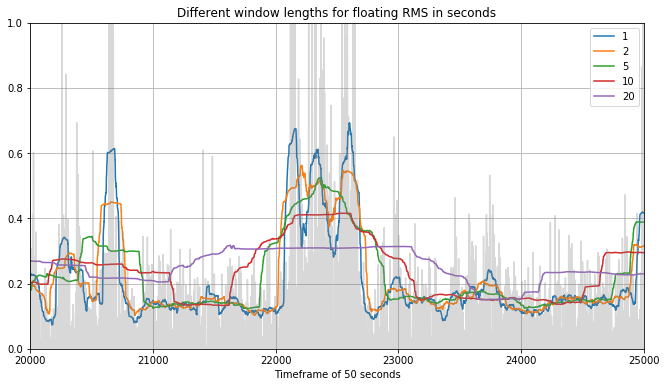

In [350]:
# different time interval
cutoff = 1.
col = 'bhp_%sHz' %str(cutoff)

s = (1, 2, 5, 10, 20)
order = 2
plt.figure(figsize = (11,6))
for i in s:
    rmn  = floating_RMN(dat['bhp_1.0Hz'],  int(fs*i), N=order)
    plt.plot(rmn)
    #print 1 - (mean_squared_error(dat[col], rmn))
plt.grid()

plt.legend(s)
plt.title('Different window lengths for floating RMS in seconds')
plt.plot(dat[col], 'grey', alpha = 0.3)
plt.xlim(20000, 25000)
plt.ylim(0,1)
plt.xlabel('Timeframe of 50 seconds')
plt.savefig('twindows.pdf')

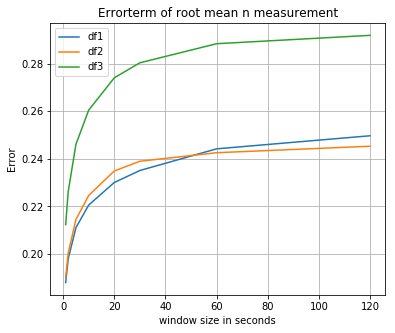

In [345]:
error_1 = (0.188079404721201,
0.1980365839437821,
0.21104006334041192,
0.2205674605241491,
0.2300391129936592,
0.23507536549183694,
0.24417834715591435,
0.24966455756344674)
error_2 = (0.19032222367102258,
0.2004643368888065,
0.21446413512750484,
0.22459355156789107,
0.23487785806227757,
0.2389605351032308,
0.24254883831374408,
0.24527353945277952)
error_3 = (0.21234661164604374,
0.2262291085003847,
0.24601796913888718,
0.2604186232848035,
0.27398560466136646,
0.2802984382123421,
0.2883130277395668,
0.2918244115857178)
plt.figure(figsize = (6,5))
plt.plot(s, error_1)
plt.plot(s, error_2)
plt.plot(s, error_3)
plt.legend(('df1','df2','df3'))
plt.grid()
plt.ylabel('Error')
plt.xlabel('window size in seconds')
plt.title('Errorterm of root mean n measurement')
plt.savefig('errorterm.pdf')

In [408]:
##### df_backpack.describe()

## highpass & RMN & Export different df
# Whole Process?


dat = df_forth3
title = 'df_forth3'

col = gI[2]
s = 2
t = 1.5
cutoff = 1.
order = 6

# check runtime
tic = time.clock()

# 1) dynamic thresholding
dat = dyn_threshold(dat, col, t=t)

fs = round(getfN(dat[:5000]),2) #sampling freq

# 2) highpass me
colpass = 'bhp_%sHz' %str(cutoff)
passmehigh(dat,col,cutoff,fs,order)

# 3) floating root mean square
colrmn = str(colpass) +'_rmn'
dat[colrmn] = floatingg_RMN(dat[colpass], int(s*fs), 2)

# 4) average of geotags
avg = average_geotags(dat, col = colrmn)

# 5) normalize
colnorm = 'N_' + colrmn 
avg[colnorm] = normalize(avg[colrmn])

# 6) export to geoJSON
processed = df_geojson(df=avg, col = colnorm)

# opt 7) safe to file directory 
try:
    # make sure export path is delivered
    
    dat_js = processed
    output_filename = '%s_c%s_s%s_t%s.geojson' % (title, cutoff, s, t)
    with open(export_path + output_filename, 'wb') as output_file:
        output_file.write(json.dumps(dat_js))
except:
    print 'Failed to Export: Unknown Error'

toc = time.clock()
print toc-tic/10000

1551.40961294


In [233]:
forth3 = processed

In [76]:
def dump(data, export_path):   
    f = open(export_path + 'processed.geojson', 'w') 
    f.write(json.dumps(data))

In [409]:
import folium

def style_function(feature):
    return {
        "color": feature['properties']['stroke'],
        "stroke-width": 2.5,
        "stroke-opacity": 1
      }

m = folium.Map(location=[48.37142643, 10.89786328], zoom_start=19)
#folium.GeoJson(_geojson, name='bikeindex', style_function=style_function).add_to(m)
folium.GeoJson(processed, name='happybikeindex', style_function=style_function).add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

#m.save('map.png')
m

# Various Plots

## Dynamic thresholding by applying average metrics

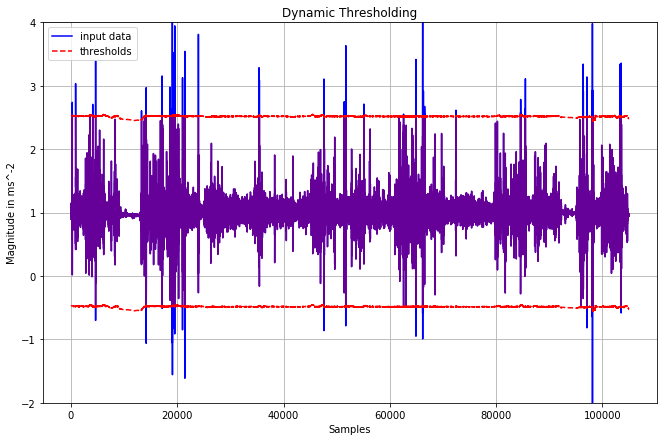

In [324]:
dat = df_forth3
col = gI[2]

t = 1.5 # g thres

fn = getfN(dat[0:5000])
w_s = 5 * fn # 5 seconds
print 'fn: ' + str(fn)

#dat_frmn = floating_RMN(dat[col], w_size= w_s,N=2)
dat_mean = dat[col].rolling(w_s, win_type = 'boxcar').mean()

#dat_mean_ = dat[col].rolling(1000, win_type = 'boxcar').mean()

#plt.plot(dat_frmn)

plt.figure(figsize = (11,7))

plt.plot(dat[col], 'x')

plt.plot(dat_mean +  t, 'r--')
plt.plot(dat_mean + -t, 'r--')

plt.plot(dat['col_t'], 'r^', alpha = 0.4)
plt.grid(any)
#plt.plot(dat_mean_*g)
plt.ylim(-2,4)
#plt.xlim(17000,20000)
plt.plot(dat_mean, 'yellow')
plt.legend(('input data', 'positive threshold', 'negative threshold','filtered','mean'), loc = 'best')

plt.ylabel('Magnitude in ms^-2')
plt.xlabel('Samples')
plt.title('Dynamic Thresholding')
#plt.savefig('df_thresholded.pdf')

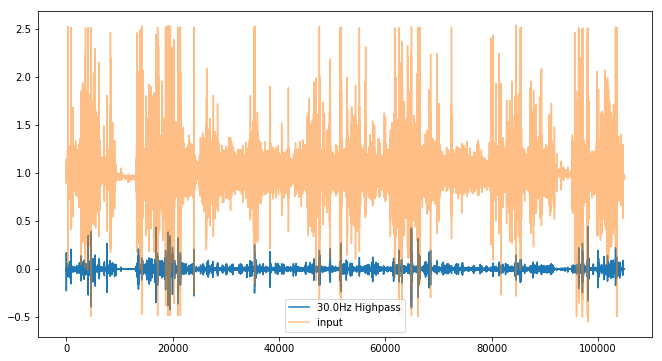

In [616]:
# compare butterworth filtered with input data 

cutoff = 30.
col = 'bhp_%sHz' %str(cutoff)
plt.figure(figsize = (11,6))
plt.plot(dat[col])
plt.plot(dat[colpass], alpha = .5)
plt.legend(( str(cutoff)+'Hz Highpass','input'));
#plt.xlim(20000,22000)
plt.savefig('passband_30.Hz.pdf')

f_n:	100
T:	0.01
mean_R:	1.01376778263


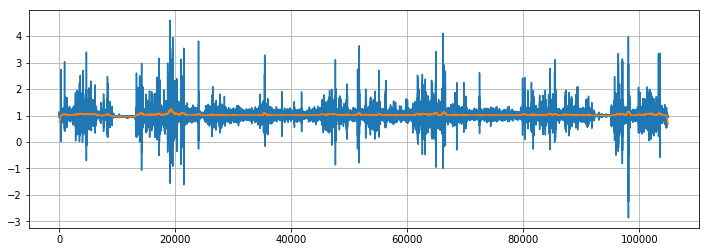

In [222]:
# calculation w sizes depending on sampling frequency
dat = df_forth1

#dat = dat.reset_index(drop = 1)

fN = getfN(dat[1:1000]) #cut to 10000 samples 
T = 1./fN


print 'f_n:\t', fN
print 'T:\t',T

# if T represents amount of samples per second
#    then a windowsize of wi = T * k covers a timeframe of k seconds
# set k empiricaly eg. 5 seconds

k = 5
wi = k * fN
rmn = floating_RMN(dat['gFz'], w_size = wi, N = 2)
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(dat['gFz'])
plt.plot(rmn)

#plt.xlim(20000,30000)
#plt.ylim(0,2)
print 'mean_R:\t', df_forth1['gFz'].mean()

0.01


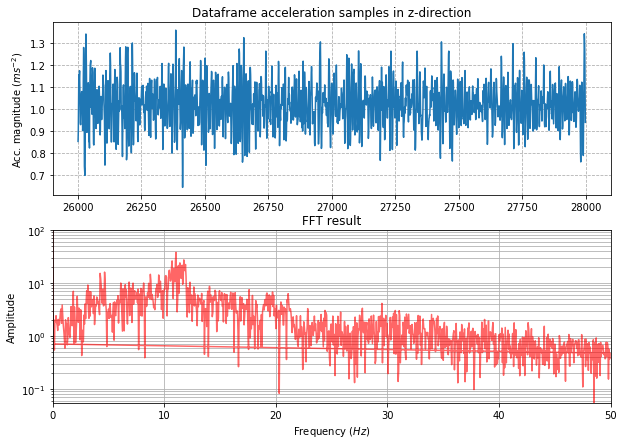

In [130]:
dat = df_forth2[26000:28000]
#dat = df_dom
fn = getfN(dat[0:3000])

dat = dat['gFz']
#dat = dat['az']
#dat = df['ag']
fft_ = abs(scipy.fft(dat))

# T ? 
T = 1./fn
freqs = scipy.fftpack.fftfreq(dat.size, T)
print T
_, ax = plt.subplots(2, sharex = False, sharey = False, figsize = (10,7))
ax[0].plot(dat)
ax[0].grid(linestyle = '--')
ax[0].set_title('Dataframe acceleration samples in z-direction')
ax[0].set_ylabel('Acc. magnitude $(ms^{-2})$')


ax[1].plot(freqs,fft_, 'r', alpha = 0.6)
ax[1].grid(linestyle = '-', which = 'both')

ax[1].set_yscale('log')
ax[1].set_ylim(0,100)

ax[1].set_title('FFT result')
ax[1].set_xlabel('Frequency ($Hz$)')
ax[1].set_ylabel('Amplitude');


#plt.semilogy()

plt.xlim(0,50)
#plt.savefig('fft_df_forth2.pdf')

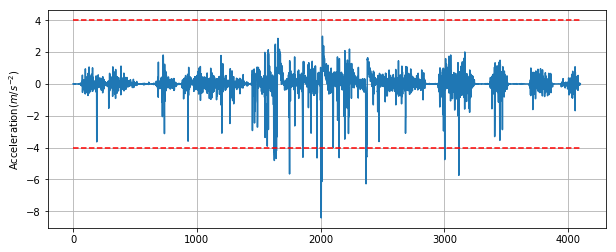

In [461]:
dat = df_polizei
plt.figure(figsize = (10,4))
plt.plot(dat['az'])

plt.plot([0,len(dat)], [4,4], 'r--')
plt.plot([0,len(dat)], [-4,-4], 'r--')

plt.grid(linestyle = '-')
plt.ylabel('Acceleration($m/s^{-2}$)')

plt.savefig('simple_thres.pdf')

0.1319288098890571
1.037578748893076


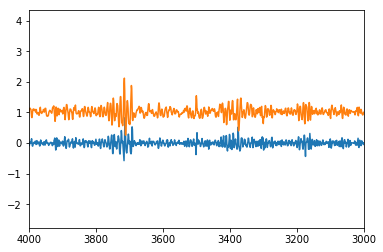

In [43]:
#derivative?

dat = df_forth2['gFz']
diff = np.diff(dat)

plt.plot(diff)
plt.plot(dat)
plt.xlim(4000,3000)
print rms(pd.Series(diff))
print rms(dat)

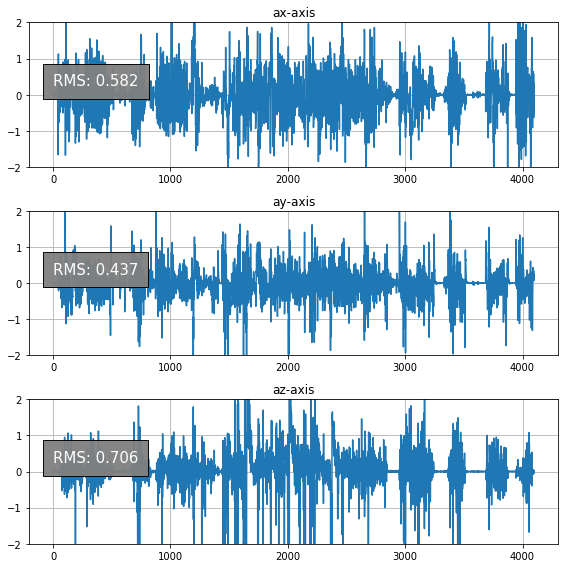

In [128]:
# PLOT XYZ

dat = df_polizei

I = ('ax','ay', 'az')

f, ax = plt.subplots(3, sharey = True, figsize = (8,8))

for i in xrange(0,3):
    ax[i].plot(dat[I[i]])
    
    _ = str(I[i]) + '-axis'
    ax[i].title.set_text(_)
    
    ax[i].text(.25,.25, 'RMS: ' + str(round(rms(dat[I[i]]),3)),
               {'color': 'w', 'fontsize': 15},  
               bbox = {'facecolor':'grey', 'alpha':0.95, 'pad':10}
              )
    ax[i].grid()

plt.ylim((-2,2))

plt.tight_layout()

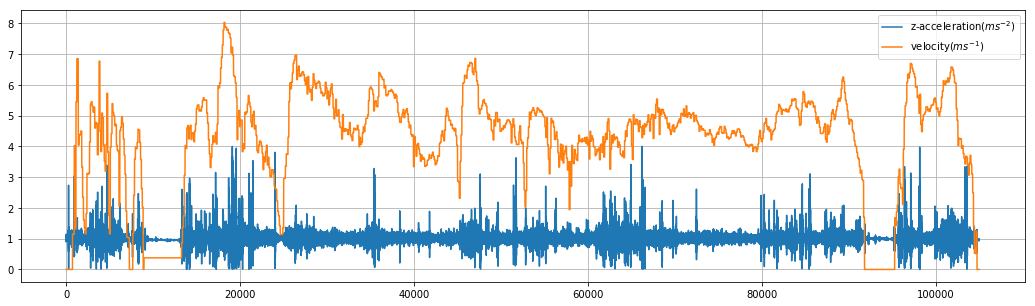

In [482]:
# thresholding 
dat = df_forth1
col = gI[2]

plt.figure(figsize=(18,5))
dat_plt = thres(abs(dat[col]), t = 4)

plt.plot(dat_plt[:])
plt.grid()
plt.plot(dat['velocity'][:])
plt.legend(['z-acceleration$(ms^{-2})$','velocity$(ms^{-1})$'])

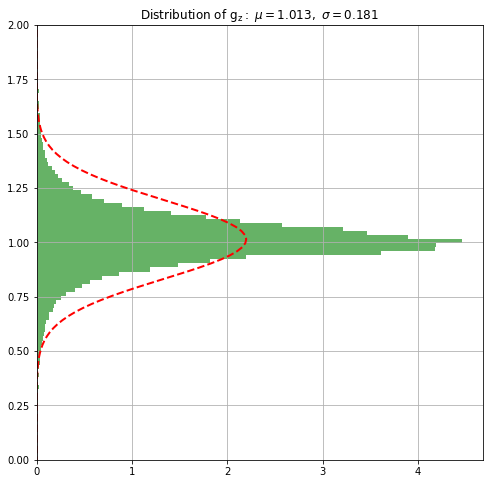

In [74]:
# fit gaussian norm on dataset

# dat = ?   -->
dat = df_forth1['gFz']

import scipy

(mu, sigma) = norm.fit(dat)

plt.figure(figsize = (8,8))
n, bins, patches = plt.hist(dat, 400, density=1, facecolor='green', alpha=0.60, orientation='horizontal')
y = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot( y,bins, 'r--', linewidth=2)

#plt.ylabel('Probability/Normed Occurence')
#plt.xlabel('z-accelerations')

plt.ylim((-0.,2.),)

#plt.plot(x_s, gauss_N)
plt.title(r'$\mathrm{Distribution\ of\ g_z:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.savefig('gaussian_az.png')
#plt.xscale('log')
plt.savefig('vertical_distribution_df_forth1.png')

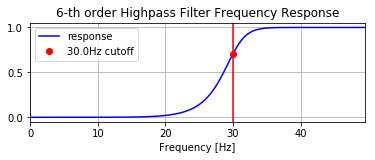

In [269]:
# https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

cutoff = 30.
order = 6

# Get the filter coefficients 
b, a = highpass_butter(cutoff, fs, order)

#
# b, a = lowpass_butter(cutoff, fs, order)

# frequency response of the filter
w, h = freqz(b, a, worN=8000)
#w, h = freqz(d, c, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5 * fs * w/np.pi, # fs*w/(2pi)
         np.abs(h),
         'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ro')
plt.axvline(cutoff, color='r')
plt.xlim(0, 0.5*fs)
plt.title(str(order)+"-th order Highpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
#plt.xscale('log')
#plt.margins(0, 0.1)
plt.legend(('response', str(cutoff)+'Hz cutoff'))
plt.grid(which='both', axis='both')
plt.savefig('lowPass_20hz.pdf')

1626
404
1222
percentage: 75.15%


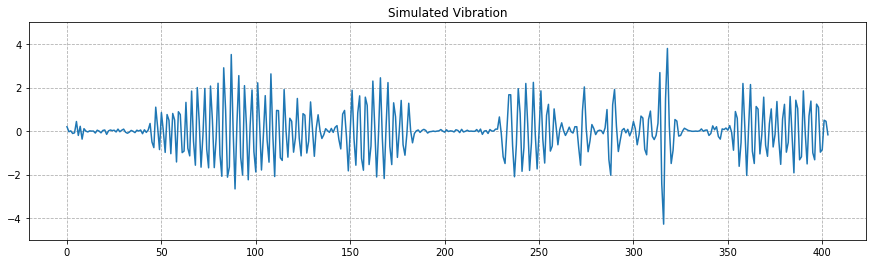

In [231]:
# simulated vibration
# linear acceleration

df_sim = import_csv(path_dat = root + 'sim.csv')
df_sim = first_process(df_sim, drop_duplicates='false')
df_simfora = dropfora(df_sim)
returndef(df_sim, df_simfora)
df_simfora = df_simfora.reset_index(drop='true')

plot_1d_broad(df_simfora['az'], ylim = [-5,5], name='Simulated Vibration')
plt.grid(linestyle = '--')

0.7060652844523373 
0.5819664779951893 
0.4369596787394774


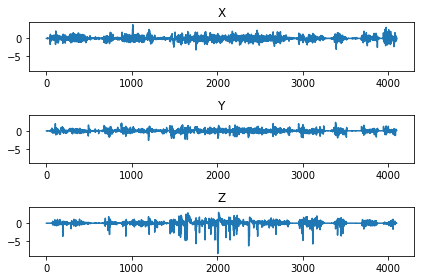

In [476]:
dat = df_polizei

z_rms_bullen = rms(dat['az'])
x_rms_bullen = rms(dat['ax'])
y_rms_bullen = rms(dat['ay'])

plot_XYZ(dat)
print z_rms_bullen,'\n', x_rms_bullen,'\n', y_rms_bullen

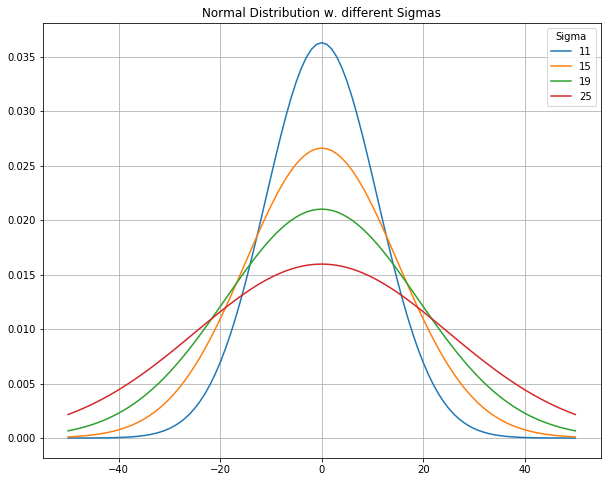

In [328]:
mu = 0 #
kernel = 101

gwindow = []

sig = [11,15,19,25]
error = []
k = kernel//2
x_axis = np.arange(-k, k+1, 1)
j = 0
plt.figure(figsize =(10,8))

for sigma in sig:
    #plt.figure(num=None, figsize=(8, 6))
    g_kernel = kernel # really?
    
    gwindow = np.array(gauss_me(g_kernel, sigma, mu))
    
    if j == 0:
        gwindows = np.array([gwindow])
    else:
        gwindows = np.vstack((gwindows, np.array(gwindow)))
        
    plt.plot(x_axis, gwindow, label = sigma)
    plt.grid(any)
    plt.legend(title = "Sigma")
    
    error.append(0)
    for i in range(0,len(gwindow)):
        error[j] += gwindow[i]
    j += 1


plt.title('Normal Distribution w. different Sigmas')
plt.savefig('gaussian_sigmas.pdf')

RMS 3: 0.63471141322109
Covariance: 0.183
RMS 9: 0.6124559284856587
Covariance: 0.152
RMS 17: 0.6008233268507613
Covariance: 0.138
RMS 25: 0.593447729051749
Covariance: 0.13


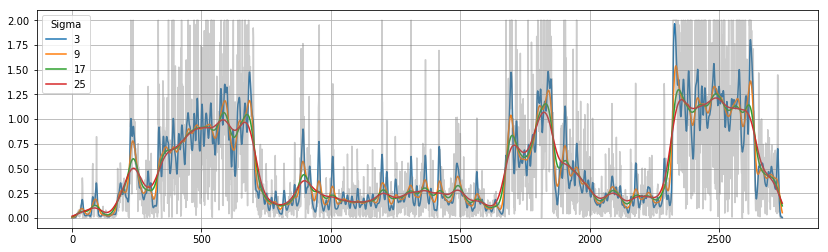

In [365]:
#dat?

dat = df_dom

sig = [3, 9, 17, 25]
stack = []
RME_list= []
RMS_list = []

col = I[2]

j = 0
plt.figure(figsize=(14,4))
plt.grid(any)

#plt.plot(dat[200:300])

for sigma in sig:
    res = np.convolve(dat[col], gauss_me(g_kernel=201, sigma=sigma), 'same')
    
    if j == 0:
        stack = np.array([res])
    else:
        stack = np.vstack((stack, np.array(res)))
        
    # append dataframe
    name_col = 'g' + str(sigma)
    dat.join( pd.Series(res,name=name_col))
    
    plt.plot(res)
    
    plt.legend(sig, title = 'Sigma', loc = 'best')
    
    #print str(sigma) + ': ' + str(round(np.var(stack[j-1]),3))
    
    cov = np.cov(dat[col], stack[j])
    rms_df = rms(pd.Series(stack[j]))
    RMS_list = np.append(RMS_list, rms_df)
    
    col_name = str(sigma) + '_g'
    
    dat[col_name] = res
    
    print 'RMS %s: %s' %(sigma, RMS_list[j])
    print 'Covariance: %s' % round(cov[0][1], 3)
    #RME_list = np.append(RME_list, mean_squared_error(dat[col], stack[j]))
    #print  'RME: %s' % RME_list[j]
    
    j = j+1
    
#plt.xlim(0,1000)
plt.plot(dat[col], 'grey', alpha = 0.4)
plt.savefig('gaussian_sigmas_compared_t2.pdf')

RMS 13: 0.6056923452501506
Covariance: 0.144
RME: 0.1610326922092278
RMS 15: 0.6030973731602562
Covariance: 0.141
RME: 0.1643587533516465
RMS 19: 0.5987757120771233
Covariance: 0.136
RME: 0.16964156256253132
RMS 25: 0.593447729051749
Covariance: 0.13
RME: 0.17530702582852725


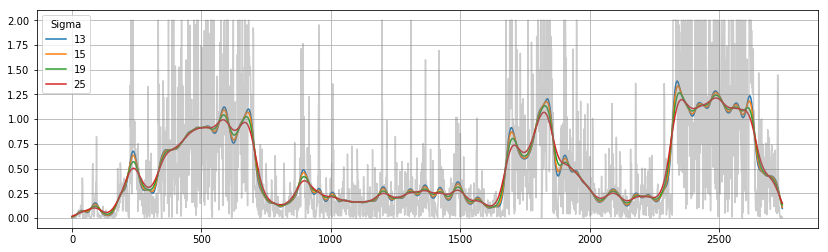

In [523]:
dat = df_dom
col = I[2]

sig = [1, 3, 5,7]

dat[col] = abs(dat[col])
dat[col] = thres(dat[col],t=2)

stack = []
RME_list= []
RMS_list = []

j = 0
plt.figure(figsize=(14,4))
plt.grid(any)
#plt.plot(dat[200:300])
for sigma in sig:
    res = np.convolve(dat[col], gauss_me(g_kernel=201, sigma=sigma), 'same')
    
    if j == 0:
        stack = np.array([res])
    else:
        stack = np.vstack((stack, np.array(res)))
    
    plt.plot(abs(res[:]))
    
    plt.legend(sig, title = 'Sigma', loc = 'best')
    
    #print str(sigma) + ': ' + str(round(np.var(stack[j-1]),3))
    
    cov = np.cov(dat[col], stack[j])
    rms_df = rms(pd.Series(stack[j]))
    RMS_list = np.append(RMS_list, rms_df)
    
    print 'RMS %s: %s' %(sigma, RMS_list[j])
    print 'Covariance: %s' % round(cov[0][1], 3)
    RME_list = np.append(RME_list, mean_squared_error(dat[col], stack[j]))
    print  'RME: %s' % RME_list[j]
    
    j = j+1
    
plt.plot(dat[col], 'grey', alpha = 0.4)
plt.savefig('gaussian_sigmas_compared_t2.pdf')

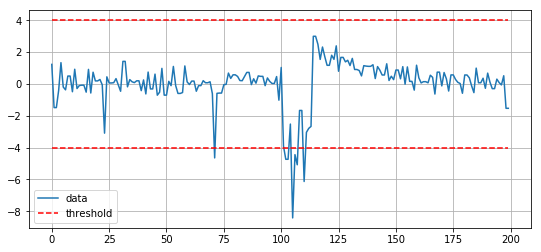

In [498]:
plt.figure(figsize = (9,4))
dat = df_polizei['az'][1900:2100].reset_index()
plt.plot(dat['az'])
neg = np.ones(len(dat))*(-4)
pos = np.ones(len(dat))*4
plt.plot(neg, 'r--')
plt.plot(pos, 'r--')

#dat.loc[dat['az'] <=-4].plot(color='r')

plt.legend(('data','threshold'))
plt.grid()
plt.savefig('simple_thres2.pdf')

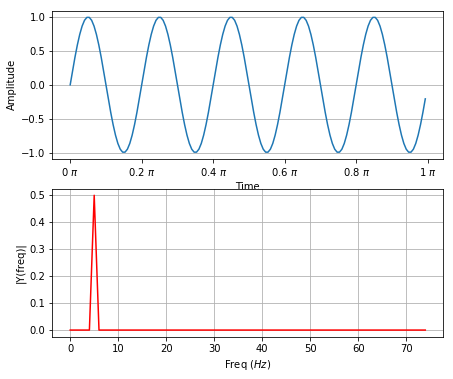

In [403]:
import matplotlib.ticker as tck

Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n/2)]

fig, ax = plt.subplots(2, 1, figsize=(7,6))

ax[0].plot(t,y)
ax[0].set_xlabel('Time')

x=np.linspace(-10*np.pi, 10*np.pi)
ax[0].xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))

ax[0].set_ylabel('Amplitude')
ax[0].grid(axis = 'y')

ax[1].plot(frq,np.abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq ($Hz$)')
ax[1].set_ylabel('|Y(freq)|');
ax[1].grid()
plt.savefig('exampleFFT.pdf')

Dispersion 13: 0.7647545045317682
Standard Deviation: 0.53845764705

Dispersion 15: 0.7772548682429415
Standard Deviation: 0.540146624192

Dispersion 25: 0.8188789262286925
Standard Deviation: 0.539101638029



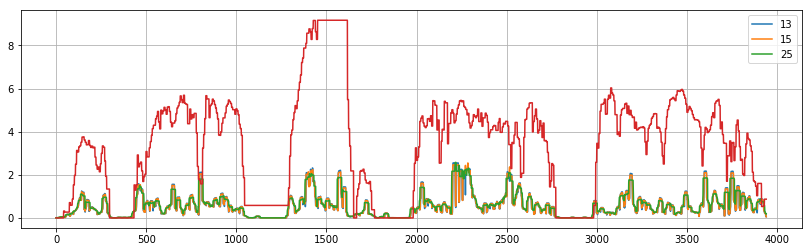

In [268]:
# Filtering w RMN
# Threshold
t = 4

dat = df_swa
dat = dat.reset_index(drop = 1)
dat['az'] = thres(abs(dat['az']),t)

# w_size
rmN = [13,15,25]
#res = floating_RMN(thres(abs(df_fora['az']),4), w_size=16, N=N)

N = 4 #Quad/Square?

j = 0

plt.figure(figsize=(14,4))
plt.grid(any)

for n in rmN:
    res = floating_RMN(dat['az'], w_size=n, N=N)
    
    if j == 0:
        stack = np.array([res])
    else:
        stack = np.vstack((stack, np.array(res)))
    
    plt.plot(abs(res[:]))
    
    #print str(sigma) + ': ' + str(round(np.var(stack[j-1]),3))
    
    print "Dispersion " + str(n) + ": " + str(rms(pd.Series(stack[j]))) 
    print 'Standard Deviation: ' + str(pd.Series(stack[j]).std())
    print
    j = j + 1
    
plt.legend(rmN);
plt.plot(dat['velocity']);